In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [149]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv", header=0)
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [150]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [151]:
columns = ['ram','storage','screen','final_price']
df = df[columns]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


<Axes: xlabel='final_price', ylabel='Count'>

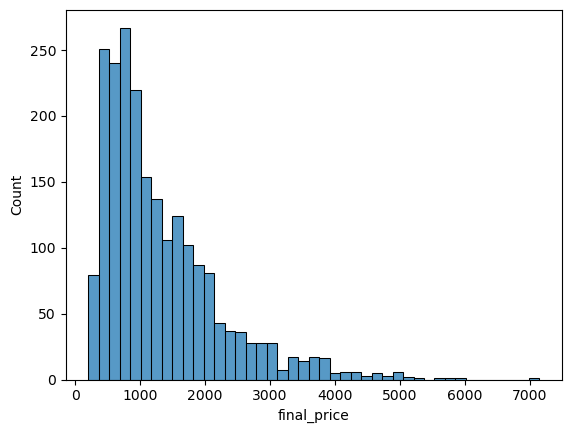

In [152]:
# EDA long tail
sns.histplot(df.final_price)

In [153]:
# 1. There's one column with missing values. What is it?
df.isnull().sum()
# screen

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [154]:
# 2. What's the median (50% percentile) for variable 'ram'?
df.ram.median()

16.0

In [155]:
# 3. Which option gives better RMSE? Both are equally good
n = df.shape[0]
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
n, n_train + n_test +n_val

(2160, 2160)

In [156]:
df_train = df.iloc[:n_train]
df_test = df.iloc[n_train:n_train+n_test]
df_val = df.iloc[n_train+n_test:]

In [157]:
# Shuffle the data
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_train = df.iloc[idx[:n_train]]
df_test = df.iloc[idx[n_train:n_train+n_test]]
df_val = df.iloc[idx[n_train+n_test:]]

In [158]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [159]:
y_train = np.log1p(df_train.final_price.values)
y_test = np.log1p(df_test.final_price.values)
y_val = np.log1p(df_val.final_price.values)

In [160]:
df_train = df_train.drop(['final_price'], axis=1)
df_test = df_test.drop(['final_price'], axis=1)
df_val = df_val.drop(['final_price'], axis=1)
df_train

,ram,storage,screen
0,32,1000,15.6
1,4,64,14.1
2,32,1000,14.0
3,16,512,13.3
4,32,1000,16.0
...,...,...,...
1291,8,256,14.0
1292,32,1000,16.0
1293,16,512,15.6
1294,16,512,14.0


In [161]:
X_train = pd.DataFrame(df_train)
X_train = X_train.fillna(0).values

In [162]:
X_val = pd.DataFrame(df_val)
X_val = X_val.fillna(0).values

In [163]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [164]:
y_pred_val = model.predict(X_train)

In [165]:
error_0 = np.sqrt(mean_squared_error(y_train, y_pred_val))
round(error_0,2)

0.45

In [166]:
X_val = pd.DataFrame(df_val)
X_val = X_val.fillna(df.ram.mean()).values

In [167]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [168]:
y_pred_val = model.predict(X_train)

In [169]:
error_mean = np.sqrt(mean_squared_error(y_train, y_pred_val))
round(error_mean,2)

0.45

In [170]:
# 4. Which r gives the best RMSE? #0

In [171]:
def prepare_X(df):
    df_num = df[columns[:-1]]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [172]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [173]:
X_train = prepare_X(df_train)

In [175]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [181]:
for r in [0, 0.01, 0.1, 1, 10,100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    X_val = prepare_X(df_val)
    y_pred = w_0 + X_val.dot(w)
    print('val', round(rmse(y_val, y_pred),2))

val 0.42
val 0.42
val 0.42
val 0.42
val 0.49
val 0.62


In [ ]:
RMSE_scores

In [ ]:
# Question 5  Closest one is 39.176
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
RMSE_scores = []
for i in seed_values:
    np.random.seed(i)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_train = df.iloc[idx[:n_train]]
    df_test = df.iloc[idx[n_train:n_train+n_test]]
    df_val = df.iloc[idx[n_train+n_test:]]
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    y_train = df_train.final_price.values
    y_test = df_test.final_price.values
    y_val = df_val.final_price.values
    df_train = df_train.drop(['final_price'], axis=1)
    df_test = df_test.drop(['final_price'], axis=1)
    df_val = df_val.drop(['final_price'], axis=1)
    X_train = pd.DataFrame(df_train)
    X_train = X_train.fillna(0).values
    X_val = pd.DataFrame(df_val)
    X_val = X_val.fillna(0).values
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    RMSE_scores.append(np.sqrt(mean_squared_error(y_val, y_pred_val)))


In [ ]:
RMSE_scores

In [ ]:
round(np.std(RMSE_scores),3)

In [ ]:
# Question 6 closest is 598.60
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)
df_train = df.iloc[idx[:n_train]]
df_test = df.iloc[idx[n_train:n_train+n_test]]
df_val = df.iloc[idx[n_train+n_test:]]
df_train = df_train+df_val
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
y_train = df_train.final_price.values
y_test = df_test.final_price.values
y_val = df_val.final_price.values
df_train = df_train.drop(['final_price'], axis=1)
df_test = df_test.drop(['final_price'], axis=1)
df_val = df_val.drop(['final_price'], axis=1)
X_train = pd.DataFrame(df_train)
X_train = X_train.fillna(0).values
X_val = pd.DataFrame(df_val)
X_val = X_val.fillna(0).values


In [ ]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
X_test = pd.DataFrame(df_test)
X_test = X_test.fillna(0).values
y_pred_val = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_val))